In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from utils.generate_data import DATA_DIR
from utils.gmm_cv import build_cross_clust_mixt_cv, compute_classification_score, create_cumsum_data
from traj_dist.cydist.basic_geographical import c_great_circle_distance


In [2]:
def create_mean_dropoff_per_cv(data_all, cv_list):
    nb_cv = len(cv_list)
    mean_dropoff_per_cv = dict([(cv,{}) for cv in range(nb_cv)])
    median_dropoff_per_cv = dict([(cv,{}) for cv in range(nb_cv)])
    for icv,cv in enumerate(cv_list):
        data_cv_train = data_all[np.logical_not(data_all.id_traj.isin(cv))]
        data_cvtcid = data_cv_train.groupby(["traj_clust","id_traj"]).last()[["lons","lats"]]

        data_cv_means = data_cvtcid.mean(level="traj_clust")
        mean_dropoff_cv = [(tc,[df.lons,df.lats]) for tc,df in data_cv_means.iterrows()]
        mean_dropoff_per_cv[icv].update(mean_dropoff_cv)

        data_cv_medians = data_cvtcid.median(level="traj_clust")
        median_dropoff_cv = [(tc,[df.lons,df.lats]) for tc,df in data_cv_medians.iterrows()]
        median_dropoff_per_cv[icv].update(median_dropoff_cv)
    return mean_dropoff_per_cv, median_dropoff_per_cv


def create_data_exp_norm(data, scores_columns):
    data_cv_score_exp = np.exp(data[scores_columns])
    inf_loc = data_cv_score_exp==np.inf
    data_cv_score_exp_norm = data_cv_score_exp.divide(data_cv_score_exp.sum(1),0)
    data_cv_score_exp_norm[inf_loc] = 1.0
    data_cv_score_exp_norm = data_cv_score_exp_norm.divide(data_cv_score_exp_norm.sum(1),0)
    return data_cv_score_exp_norm



def create_data_pct_score(data, cv_list):
    scores_columns = filter(lambda c: c.startswith("score_"), data.columns)
    data_score_norm = []
    for icv in range(len(cv_list)):
        data_cv_test = data[data.id_traj.isin(cv_list[icv])]
        data_cv_score_exp_norm = create_data_exp_norm(data_cv_test, scores_columns)
        data_score_norm.append(data_cv_score_exp_norm)
    data_pct_score_df = pd.concat(data_score_norm).reindex(data.index)
    return data_pct_score_df



def create_dropoff_dic_per_traj(data):
    dropoff_dic = dict([(id,[df.lons,df.lats]) for id,df in data.groupby("id_traj")[["lons","lats"]].last(
            ).iterrows()])
    return dropoff_dic


def create_pred_columns(data,scores_columns):
    pred_columns = data[scores_columns].idxmax(1).apply(lambda t:t.split(
                "_")[-1])
    return pred_columns


def row_pred_dist_1(row, dropoff_dic, dics):
    coord_dropoff_row =  dropoff_dic[row[0]]
    lons_row = coord_dropoff_row[0]
    lats_row = coord_dropoff_row[1]
    pred = row[1]
    lons_pred = dics[pred][0]
    lats_pred = dics[pred][1]
    dist = c_great_circle_distance(lons_row, lats_row, lons_pred, lats_pred)
    return dist

def create_pred_dist_columns_1(data, dropoff_dic, mean_dropoff_cv):
    ds = data[["id_traj", "pred"]].values
    pred_dist_columns_1 = map(lambda d : row_pred_dist_1(d,dropoff_dic,mean_dropoff_cv),ds)
    return pred_dist_columns_1


def row_pred_dist_2_(row, dropoff_dic):
    coord_dropoff_row =  dropoff_dic[row[2]]
    lons_row = coord_dropoff_row[0]
    lats_row = coord_dropoff_row[1]
    lons_pred = row[0]
    lats_pred = row[1]
    dist = c_great_circle_distance(lons_row, lats_row, lons_pred, lats_pred)
    return dist

def create_pred_dist_columns_2(data, dropoff_dic, mean_dropoff_cv,scores_columns):
    lons_line = [mean_dropoff_cv[int(c.split("_")[-1])][0] if int(c.split("_")[-1]) in
                                                 mean_dropoff_cv.keys() else 0   for c in  scores_columns]
    lons_lines = [lons_line for _ in range(len(data))]
    lons_dest  = pd.DataFrame(lons_lines,index=data.index, columns=scores_columns)


    lats_line = [mean_dropoff_cv[int(c.split("_")[-1])][1] if int(c.split("_")[-1]) in
                                                 mean_dropoff_cv.keys() else 0   for c in scores_columns]
    lats_lines = [lats_line for _ in range(len(data))]
    lats_dest  = pd.DataFrame(lats_lines,index=data.index, columns=scores_columns)

    lons_dest_pct = (lons_dest.multiply(data[scores_columns])).sum(1)
    lats_dest_pct = (lats_dest.multiply(data[scores_columns])).sum(1)

    pred_dist_columns_2 = map(lambda d : row_pred_dist_2_(d,dropoff_dic),zip(lons_dest_pct,lats_dest_pct,
                                                                            data["id_traj"]))

    return pred_dist_columns_2


def create_data_preds(data, cv_list):

    data_preds = []
    scores_columns = filter(lambda c: c.startswith("score_"), data.columns)
    for icv in range(len(cv_list)):
        data_cv_test = data[data.id_traj.isin(cv_list[icv])]    
        dropoff_dic = create_dropoff_dic_per_traj(data_cv_test)


        data_cv_test.loc[:,"pred"] = create_pred_columns(data_cv_test,scores_columns).astype(int)
        data_cv_test["dist_1"] = create_pred_dist_columns_1(data_cv_test, dropoff_dic, mean_dropoff_per_cv[icv])
        data_cv_test["dist_2"] = create_pred_dist_columns_2(data_cv_test, dropoff_dic, mean_dropoff_per_cv[icv], scores_columns)
        data_preds.append(data_cv_test)
    data_preds = pd.concat(data_preds).reindex(data.index)
    return data_preds

def create_data_preds(data, mean_dropoff_per_cv, cv_list):

    data_preds = []
    scores_columns = filter(lambda c: c.startswith("score_"), data.columns)
    for icv in range(len(cv_list)):
        data_cv_test = data[data.id_traj.isin(cv_list[icv])]    
        dropoff_dic = create_dropoff_dic_per_traj(data_cv_test)


        data_cv_test.loc[:,"pred"] = create_pred_columns(data_cv_test,scores_columns).astype(int)
        data_cv_test["dist_1"] = create_pred_dist_columns_1(data_cv_test, dropoff_dic, mean_dropoff_per_cv[icv])
        data_cv_test["dist_2"] = create_pred_dist_columns_2(data_cv_test, dropoff_dic, mean_dropoff_per_cv[icv], scores_columns)
        data_preds.append(data_cv_test)
    data_preds = pd.concat(data_preds).reindex(data.index)
    return data_preds


def build_exogenous_data(data, lname):

    #dist update
    data_coord = data[["lons", "lats", "id_traj"]].values
    dist = map(lambda x,y : 0 if x[2] != y[2] else c_great_circle_distance(x[0], x[1], y[0], y[1]),
               data_coord[:-1],data_coord[1:])
    data.loc[:,"dist"] = np.hstack((0, dist))
    data.loc[:,"rdist"] = data.groupby("id_traj")['dist'].apply(lambda x: x.cumsum())
    length_trip_per_traj = dict(data.groupby("id_traj")["rdist"].last())
    data.loc[:,"rdist_pct"] = data.rdist.values/np.array([length_trip_per_traj[x] for x in data.id_traj],dtype=float)


In [8]:
## Caltrain
print("Caltrain Dataset")

# Download cv_list (for result reproduction)
output_cv = DATA_DIR + "cv_list_Caltrain.pkl"
cv_list = pickle.load(open(output_cv, "r"))

# Download data
data_original = pd.read_pickle(DATA_DIR + "Caltrain.pkl")[["id_traj", "lons", "lats"]].reset_index(drop=True)
nb_traj = len(data_original.id_traj.unique())


# Download trajectory's cluster labels
labels = pickle.load(open(DATA_DIR+"caltrain_traj_labels.pkl", "rb"))
nb_traj_class = labels.max()+1
data_original["traj_clust"] = [labels[idt] for idt in data_original.id_traj]


# Download GMM scores and compute cumulate score of trajectories
data_score = pd.read_pickle("data/gmm_scores_Caltrain.pkl")
data_cumsum = create_cumsum_data(data_score)

# Create pct score
data_pct_score = create_data_pct_score(data_original.join(data_cumsum), cv_list)
data = data_original.join(data_pct_score)

# Create Mean dropoff per cv
mean_dropoff_per_cv, median_dropoff_per_cv = create_mean_dropoff_per_cv(data_original, cv_list)

# Compute distance
data_preds = create_data_preds(data, mean_dropoff_per_cv, cv_list)

build_exogenous_data(data_preds, "Caltrain")

Caltrain Dataset


In [4]:
completion_range = np.arange(0, 1.05, 0.05)

def create_mean_dist_per_dr(data_all, completion_range):
    dist_columns = filter(lambda c: c.startswith("dist"), data_all.columns)
    mean_dist_per_dr =  {}
    for comp in completion_range:
        data_comp = data_all[data_all.rdist_pct<=comp]
        data_gbit_mean = data_comp.groupby("id_traj").last().mean()
        mean_dist_per_dr.update({int(comp*100) : dict(data_gbit_mean[dist_columns]) })
        mean_dist_per_dr[int(comp*100)].update({"rdist_pct_mean" : data_gbit_mean["rdist_pct"]*100})
    return mean_dist_per_dr

mean_dist_per_dr = create_mean_dist_per_dr(data_preds, completion_range)


In [5]:
def create_data_dic_plot_compare_method_nb_cluster(data_dic_plot, completion_range):
    data_plot = []
    for comp in completion_range:
        data_plot.append([comp,data_dic_plot[comp]["dist_1"],data_dic_plot[comp]["dist_2"]])
    data_plot = np.array( sorted(data_plot,key=lambda j : j[0]) )
    return data_plot


def plot_prediction_final_destination_compare_method(fig, ax, data_plot, labels, plot_ind, x_range,color_dic,
                                                fix_param='',title=None,xlabel=None,
                                                ylabel="Mean error prediction \n to the destination (in Km)",loc=0,
                                                ylim="None" ):
        min_dist = np.inf
        max_dist = - np.inf
        for eni,label in enumerate(labels):
            ax.plot(data_plot[:,0], data_plot[:,eni+1], color=color_dic[label], label=label, marker=".",linewidth=3)
            min_dist = min(min_dist, np.nanmin(data_plot[:,eni+1]))
            max_dist = max(max_dist, np.nanmax(data_plot[:,eni+1]))
        min_dist = min_dist - min_dist % 50
        max_dist = (max_dist + 50) - (max_dist + 50) % 50
        for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(25)
        ax.set_ylabel(ylabel, fontsize=35)

        ax.set_xticks(x_range)
        for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(25)
            tick.label.set_rotation(45)

        ax.set_ylim(min_dist, max_dist)
        ax.yaxis.grid(True)
        ax.xaxis.grid(True)
        if fix_param =="accomplishement":
            ax.set_xticklabels(map(lambda x : str(int(x)),x_range))
            if title is None:
                ax.set_title("Mean Error Prediction of VS Number of Cluster P  \n Percentage of accomplishment : %.2f"
                         %plot_ind, fontsize=32)
            else:
                ax.set_title(title, fontsize=45)
            if xlabel is None:
                ax.set_xlabel("Number of Cluster", fontsize=35)
            else:
                ax.set_xlabel(xlabel, fontsize=35)
        elif fix_param =="nb_cluster":
            xtl = [str(x) if x%10==0 else "" for x in x_range]
            ax.set_xticklabels(xtl)
            if title is None:
                ax.set_title("Mean Error Prediction of VS Number of Cluster P  \n Number of clusters : %d"
                         %plot_ind, fontsize=32)
            else:
                ax.set_title(title, fontsize=45)
            if xlabel is None:
                ax.set_xlabel("Trajectory Accomplishment", fontsize=35)
            else:
                ax.set_xlabel(xlabel, fontsize=35)
        else:
            raise ValueError
        if ylim!="None":
            ax.set_ylim(ylim[0],ylim[1])
            ax.set_yticks(np.arange(ylim[0], ylim[1]+50 ,50))
            ax.set_yticklabels([str(float(x)/1000) if x%200==0 else ""  for x in np.arange(ylim[0], ylim[1]+50 , 50)])
        else:
            ax.set_ylim(min_dist, max_dist)
            ax.set_yticks(np.arange(min_dist, max_dist+50 ,50))
            ax.set_yticklabels([str(float(x)/1000) for x in np.arange(min_dist, max_dist+50 , 50)])

        if not("Porto" in title):
            plt.legend(loc=loc, fontsize=25)

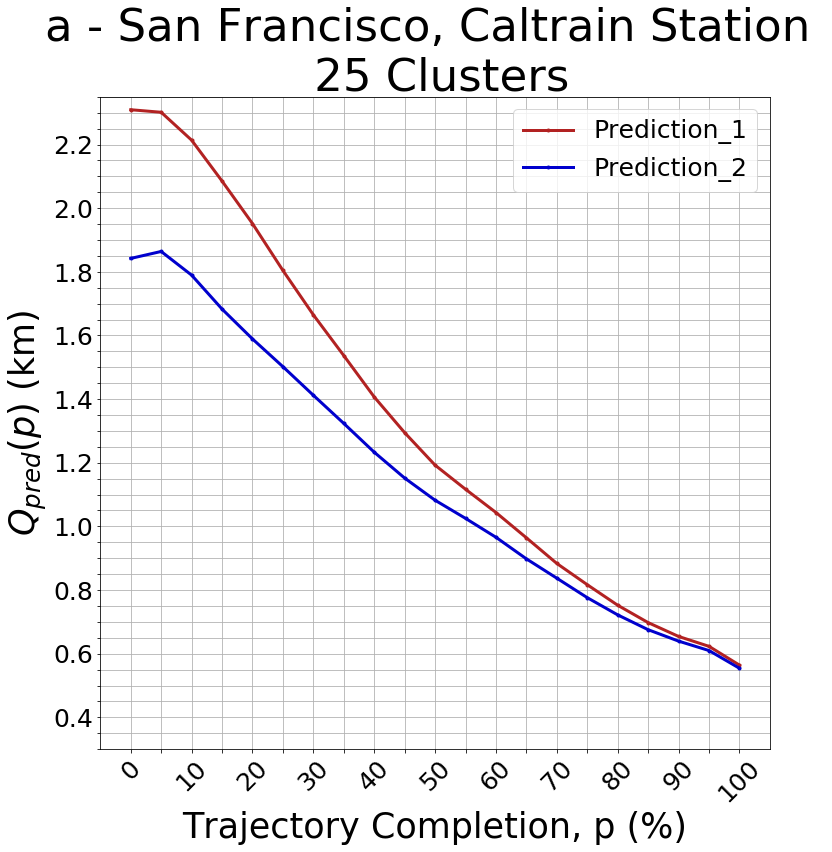

In [6]:
completion_range = np.arange(0, 105, 5)
METHOD_COLOR = {
 "Prediction_1" : "firebrick",
 "Prediction_2" : "mediumblue",
}
nbc=25
data_plot = create_data_dic_plot_compare_method_nb_cluster(mean_dist_per_dr, completion_range)
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1)
labels = ["Prediction_1", "Prediction_2"]
title = "a - San Francisco, Caltrain Station \n 25 Clusters"
xlabel = "Trajectory Completion, p (%)"
ylabel = r"$Q_{pred}(p)$ (km)"
plot_prediction_final_destination_compare_method(fig, ax, data_plot, labels, nbc, completion_range,
                                                 METHOD_COLOR,
                                                 "nb_cluster", title, xlabel, ylabel, loc=1, ylim=[300, 2350])
plt.show()

In [7]:
labels

['Prediction_1', 'Prediction_2']